# Federated Learning do Zero

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [3]:
Dados = pd.read_csv('Datasets/banknote/data_banknote_authentication.csv')
Dados = Dados.to_numpy()
Dados

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699,   0.     ],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ,   0.     ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645,   0.     ],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ,   1.     ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ,   1.     ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ,   1.     ]])

In [4]:
m, n = Dados.shape # m número de linhas (amostras) n número de colunas
n0 = n - 1 #n0 número de  (variáveis de entrada/dimensões)

In [5]:
n0

4

In [6]:
randseq = np.random.permutation(m)
dados = Dados[randseq[0:m], 0:n]

In [7]:
#Separar dados de cliente 
trainval = math.floor(m*0.8) 
testval= m - trainval

print(trainval, testval)

1097 275


In [8]:
NumofClients = 10

vec = np.random.randint(5, trainval, NumofClients)
total = np.sum(vec)
list_clients = (np.ceil((vec/total)*trainval)).astype(int)
rem = trainval - np.sum(list_clients)
list_clients[-1] = list_clients[-1] + rem

In [9]:
list_clients

array([185, 100, 116,  27, 163,  43,  18, 210, 146,  89])

In [10]:
#Separar dados para os clientes
for i in range(NumofClients):
    if i == 0:
        SplitData = dados[0:list_clients[0], :]
    else:
         SplitData = dados[np.sum(list_clients[0:i]):np.sum(list_clients[0:i])+list_clients[i], :]
    pd.DataFrame(SplitData).to_csv("data_split/data_split_"+str(i+1)+ ".csv", header=False, index=False)        

In [11]:
X_test = dados[trainval:m+1, 0:n0].T
y_test = dados[trainval:m+1, n0].reshape(1, m-trainval)

In [12]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [13]:
# Hiperparâmetros
L = 4
nx = np.array([n0, 5, 5, 1]) #neurônios por camada

learning_rate = 0.05
iterations = 10
rounds = 100

In [14]:
# Inicialização do modelo global pelo Servidor

W1 = np.random.randn(nx[1],nx[0])
b1 = np.random.randn(nx[1],1)

W2 = np.random.randn(nx[2],nx[1])
b2 = np.random.randn(nx[2],1)

W3 = np.random.randn(nx[3],nx[2])
b3 = np.random.randn(nx[3],1)

#Salvando o modelo global em arquivos CSV

pd.DataFrame(W1).to_csv("avg_parameters/W1_avg.csv", header=False, index=False)
pd.DataFrame(b1).to_csv("avg_parameters/b1_avg.csv", header=False, index=False)

pd.DataFrame(W2).to_csv("avg_parameters/W2_avg.csv", header=False, index=False)
pd.DataFrame(b2).to_csv("avg_parameters/b2_avg.csv", header=False, index=False)

pd.DataFrame(W3).to_csv("avg_parameters/W3_avg.csv", header=False, index=False)
pd.DataFrame(b3).to_csv("avg_parameters/b3_avg.csv", header=False, index=False)

In [15]:
Avg_Loss = np.zeros((rounds,1))
Accuracy = np.zeros((rounds,1))

for r in range(rounds):

    for client in range(NumofClients): 

        
        Data_X = pd.read_csv("data_split/data_split_"+str(client+1)+".csv", header=None)
        Data_X = Data_X.to_numpy()

        m_X, n_X = Data_X.shape
        n0 = n_X - 1

        X_train = Data_X[:, 0:n0].T
        y_train = Data_X[:, n0].reshape(1, m_X)

        # Each client uses the global model received from 
        # the server in the first iteration
        W1 = pd.read_csv("avg_parameters/W1_avg.csv", header=None)
        W1 = W1.to_numpy()

        W2 = pd.read_csv("avg_parameters/W2_avg.csv", header=None)
        W2 = W2.to_numpy()

        W3 = pd.read_csv("avg_parameters/W3_avg.csv", header=None)
        W3 = W3.to_numpy()

        b1 = pd.read_csv("avg_parameters/b1_avg.csv", header=None)
        b1 = b1.to_numpy()

        b2 = pd.read_csv("avg_parameters/b2_avg.csv", header=None)
        b2 = b2.to_numpy()

        b3 = pd.read_csv("avg_parameters/b3_avg.csv", header=None)
        b3 = b3.to_numpy()

        J = np.zeros((iterations,1))

        for i in range(iterations):

            # Forward propagation
            Z1 = np.dot(W1, X_train) + b1
            A1 = sigmoid(Z1)

            Z2 = np.dot(W2, A1) + b2
            A2 = sigmoid(Z2)

            Z3 = np.dot(W3, A2) + b3
            A3 = sigmoid(Z3)

            # J[i] = (-1/m_X)*np.sum(y_train*np.log(A3) + (1-y_train)*np.log(1-A3))
            
            # Backward propagation
            dZ3 = A3-y_train
            dW3 = (1/m_X)*np.dot(dZ3, A2.T)
            db3 = (1/m_X)*np.sum(dZ3, axis = 1, keepdims = True)

            dA2 = A2*(1-A2)
            dZ2 = np.dot(W3.T, dZ3)*dA2
            dW2 = (1/m_X)*np.dot(dZ2, A1.T)
            db2 = (1/m_X)*np.sum(dZ2, axis = 1, keepdims = True)

            dA1 = A1*(1-A1)
            dZ1 = np.dot(W2.T, dZ2)*dA1
            dW1 = (1/m_X)*np.dot(dZ1, X_train.T)
            db1 = (1/m_X)*np.sum(dZ1, axis = 1, keepdims = True)

            W1 = W1 - learning_rate*dW1
            b1 = b1 - learning_rate*db1

            W2 = W2 - learning_rate*dW2
            b2 = b2 - learning_rate*db2

            W3 = W3 - learning_rate*dW3
            b3 = b3 - learning_rate*db3

        # Each client sends the local models to
        # the server
        pd.DataFrame(W1*m_X).to_csv("ind_parameters/W1_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W2*m_X).to_csv("ind_parameters/W2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W3*m_X).to_csv("ind_parameters/W3_"+str(client+1)+".csv", header=False, index=False)

        pd.DataFrame(b1*m_X).to_csv("ind_parameters/b1_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b2*m_X).to_csv("ind_parameters/b2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b3*m_X).to_csv("ind_parameters/b3_"+str(client+1)+".csv", header=False, index=False)

    # The server aggregate/average the local models

    W1 = np.zeros([nx[1],nx[0]]) 
    b1 = np.zeros([nx[1],1])

    W2 = np.zeros([nx[2],nx[1]]) 
    b2 = np.zeros([nx[2],1])

    W3 = np.zeros([nx[3],nx[2]])
    b3 = np.zeros([nx[3],1])

    for client in range(NumofClients):
        W1 = W1 + pd.read_csv("ind_parameters/W1_"+str(client+1)+".csv", header=None)
        W2 = W2 + pd.read_csv("ind_parameters/W2_"+str(client+1)+".csv", header=None)
        W3 = W3 + pd.read_csv("ind_parameters/W3_"+str(client+1)+".csv", header=None)

        b1 = b1 + pd.read_csv("ind_parameters/b1_"+str(client+1)+".csv", header=None)
        b2 = b2 + pd.read_csv("ind_parameters/b2_"+str(client+1)+".csv", header=None)
        b3 = b3 + pd.read_csv("ind_parameters/b3_"+str(client+1)+".csv", header=None)

    W1 = W1.to_numpy()
    W2 = W2.to_numpy()
    W3 = W3.to_numpy()

    b1 = b1.to_numpy()
    b2 = b2.to_numpy()
    b3 = b3.to_numpy()

    W1_avg = W1/trainval
    W2_avg = W2/trainval
    W3_avg = W3/trainval

    b1_avg = b1/trainval
    b2_avg = b2/trainval
    b3_avg = b3/trainval

    pd.DataFrame(W1_avg).to_csv("avg_parameters/W1_avg.csv", header=False, index=False)
    pd.DataFrame(W2_avg).to_csv("avg_parameters/W2_avg.csv", header=False, index=False)
    pd.DataFrame(W3_avg).to_csv("avg_parameters/W3_avg.csv", header=False, index=False)

    pd.DataFrame(b1_avg).to_csv("avg_parameters/b1_avg.csv", header=False, index=False)
    pd.DataFrame(b2_avg).to_csv("avg_parameters/b2_avg.csv", header=False, index=False)
    pd.DataFrame(b3_avg).to_csv("avg_parameters/b3_avg.csv", header=False, index=False)

    # Evaluation of the global model on
    # the testing dataset
    Z1 = np.dot(W1_avg, X_test) + b1_avg
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2_avg, A1) + b2_avg
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3_avg, A2) + b3_avg
    A3 = sigmoid(Z3)

    Avg_Loss[r] = (-1/m)*np.sum(y_test*np.log(A3) + (1-y_test)*np.log(1-A3))

    y_pred = A3 > 0.5
    Accuracy[r] = 1 - np.sum(abs(y_pred - y_test))/testval

    print(f"Round: {r+1}, Loss: {Avg_Loss[r]}, Accuracy: {Accuracy[r]}")


Round: 1, Loss: [0.38987171], Accuracy: [0.59636364]
Round: 2, Loss: [0.29494204], Accuracy: [0.59636364]
Round: 3, Loss: [0.21988434], Accuracy: [0.59636364]
Round: 4, Loss: [0.17021145], Accuracy: [0.59636364]
Round: 5, Loss: [0.14248039], Accuracy: [0.59636364]
Round: 6, Loss: [0.12889255], Accuracy: [0.59636364]
Round: 7, Loss: [0.12231539], Accuracy: [0.59636364]
Round: 8, Loss: [0.11867678], Accuracy: [0.66181818]
Round: 9, Loss: [0.11607543], Accuracy: [0.69454545]
Round: 10, Loss: [0.11372645], Accuracy: [0.70545455]
Round: 11, Loss: [0.11134661], Accuracy: [0.72363636]
Round: 12, Loss: [0.10885161], Accuracy: [0.73090909]
Round: 13, Loss: [0.10622417], Accuracy: [0.73818182]
Round: 14, Loss: [0.10346605], Accuracy: [0.75636364]
Round: 15, Loss: [0.10058545], Accuracy: [0.81818182]
Round: 16, Loss: [0.0975947], Accuracy: [0.87272727]
Round: 17, Loss: [0.09451542], Accuracy: [0.89090909]
Round: 18, Loss: [0.09139856], Accuracy: [0.89454545]
Round: 19, Loss: [0.08833352], Accurac

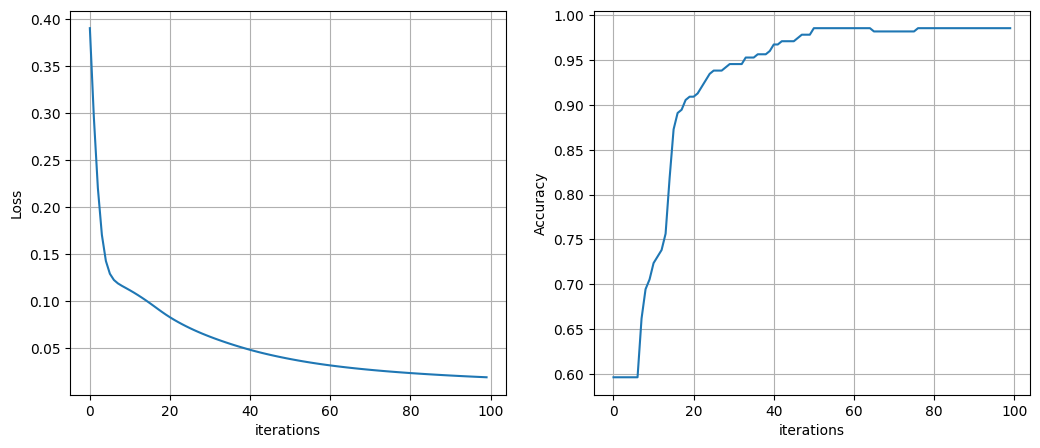

In [16]:
plt.subplot(1, 2, 1)
plt.plot(Avg_Loss)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(Accuracy)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Accuracy')

plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()